# PDE-Net for Convection-Diffusion Equation

## Overview

PDE-Net is a feedforward deep network proposed by Zichao Long et al. to learn partial differential equations from data, predict the dynamic characteristics of complex systems accurately and uncover potential PDE models. The basic idea of PDE-Net is to approximate differential operators by learning convolution kernels (filters). Neural networks or other machine learning methods are applied to fit unknown nonlinear responses. Numerical experiments show that the model can identify the observed dynamical equations and predict the dynamical behavior over a relatively long period of time, even in noisy environments. More information can be found in [PDE-Net: Learning PDEs from Data](https://arxiv.org/abs/1710.09668).

This notebook requires **MindSpore version >= 2.0.0** to support new APIs including: *mindspore.jit, mindspore.jit_class, mindspore.data_sink*.

## Problem Description

This case solves the inverse problem of convection-diffusion partial differential equations with variable parameters and realizes long-term prediction.

## Governing Equation

In this case, the convection-diffusion equation is of the form:

$$
u_t = a(x,y) u_x + b(x,y) u_y + c u_{xx} + d u_{yy}, \quad (x,y) \in[0,2 \pi] \times[0,2 \pi]
$$

$$
u|_{t=0} = u_0(x,y)
$$

The coefficients of each derivative are:

$$
a(x,y)=0.5(cos(y)+x(2\pi-x)sin(x))+0.6 \quad
b(x,y)=2(cos(y)+sin(x))+0.8
$$

$$
c=0.2 \quad
d=0.3
$$


## Model Structure of the PDE-Net

The PDE-Net consists of multiple $\delta T$ Blocks in series to implement prediction of long sequence information. Each $\delta T$ Block includes several moment matrixes of trainable parameters. The matrixes can be converted to convolution kernels according to a mapping relationship. Thereby the derivatives of the physical field can be obtained. After linearly combining the derivative and its corresponding physical quantity, the information of the next time step can be deduced by using the forward Euler method.

![](images/pdenet-1.jpg)

![](images/pdenet-2.jpg)

## Technology Path

MindFlow solves the problem as follows:

1. Model Construction.
2. Single Step Training.
3. Multi-step Training.
4. Model Evaluation and Visualization.

In [1]:
import os
import time
import numpy as np

import mindspore
from mindspore.common import set_seed
from mindspore import nn, Tensor, context, ops, jit
from mindspore.train.serialization import load_param_into_net

In [2]:
from mindflow.cell import PDENet
from mindflow.utils import load_yaml_config
from mindflow.loss import get_loss_metric, RelativeRMSELoss
from mindflow.pde import UnsteadyFlowWithLoss

from src import init_model, create_dataset, calculate_lp_loss_error
from src import make_dir, scheduler, get_param_dic
from src import plot_coe, plot_extrapolation_error, get_label_coe, plot_test_error

In [3]:
set_seed(0)
np.random.seed(0)
context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=0)

In [4]:
# load configuration yaml
config = load_yaml_config('./configs/pde_net.yaml')

## Model Construction

MindFlow provides the `PDENet` interface to directly create a PDE-Net model. You need to specify the width, height, data depth, boundary condition, and highest order of fitting.

In [5]:
def init_model(config):
    return PDENet(height=config["mesh_size"],
                  width=config["mesh_size"],
                  channels=config["channels"],
                  kernel_size=config["kernel_size"],
                  max_order=config["max_order"],
                  dx=2 * np.pi / config["mesh_size"],
                  dy=2 * np.pi / config["mesh_size"],
                  dt=config["dt"],
                  periodic=config["perodic_padding"],
                  enable_moment=config["enable_moment"],
                  if_fronzen=config["if_frozen"],
                  )

## Single Step Training

The parameters of each $\delta T$ block are shared. Therefore, the model is trained one by one based on the number of connected $\delta T$ blocks. When step is 1, the model is in the warm-up phase. The moments of the PDE-Net are frozen. The parameters in the moments are not involved in training. Each time a $\delta T$ block is added, the program generates data and reads data sets. After the model is initialized, the program loads the checkpoint trained in the previous step, defines the optimizer, mode, and loss function. During training process, the model reflects the model performance in real time based on the callback function.

In [6]:
def train_single_step(step, config, lr, train_dataset, eval_dataset):
    """train PDE-Net with advancing steps"""

    print("Current step for train loop: {}".format(step, ))
    model = init_model(config)

    epoch = config["epochs"]
    warm_up_epoch_scale = 10
    if step == 1:
        model.if_fronzen = True
        epoch = warm_up_epoch_scale * epoch
    elif step == 2:
        param_dict = get_param_dic(config["summary_dir"], step - 1, epoch * 10)
        load_param_into_net(model, param_dict)
        print("Load pre-trained model successfully")
    else:
        param_dict = get_param_dic(config["summary_dir"], step - 1, epoch)
        load_param_into_net(model, param_dict)
        print("Load pre-trained model successfully")

    optimizer = nn.Adam(model.trainable_params(), learning_rate=Tensor(lr))
    problem = UnsteadyFlowWithLoss(model, t_out=step, loss_fn=RelativeRMSELoss(), data_format="NTCHW")

    def forward_fn(u0, uT):
        loss = problem.get_loss(u0, uT)
        return loss

    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    @jit
    def train_step(u0, uT):
        loss, grads = grad_fn(u0, uT)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    steps = train_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, train_dataset, sink_size=1)

    for cur_epoch in range(epoch):
        local_time_beg = time.time()
        model.set_train()

        for _ in range(steps):
            cur_loss = sink_process()
            print("epoch: %s, loss is %s" % (cur_epoch + 1, cur_loss), flush=True)
        local_time_end = time.time()
        epoch_seconds = (local_time_end - local_time_beg) * 1000
        step_seconds = epoch_seconds / steps
        print("Train epoch time: {:5.3f} ms, per step time: {:5.3f} ms".format
              (epoch_seconds, step_seconds), flush=True)

        if (cur_epoch + 1) % config["save_epoch_interval"] == 0:
            ckpt_file_name = "pdenet_step_{}".format(step)
            ckpt_dir = os.path.join(config["summary_dir"], ckpt_file_name)
            if not os.path.exists(ckpt_dir):
                make_dir(ckpt_dir)
            ckpt_name = "pdenet-{}.ckpt".format(cur_epoch + 1, )
            mindspore.save_checkpoint(model, os.path.join(ckpt_dir, ckpt_name))

        if (cur_epoch + 1) % config['eval_interval'] == 0:
            calculate_lp_loss_error(problem, eval_dataset, config["batch_size"])

## Multi-step Training

The PDE-Net is trained step by step.
With **MindSpore version >= 2.0.0**, we can use the functional programming for training neural networks.

In [7]:
def train(config):
    lr = config["lr"]
    for i in range(1, config["multi_step"] + 1):
        db_name = "train_step{}.mindrecord".format(i)
        dataset = create_dataset(config, i, db_name, "train", data_size=2 * config["batch_size"])
        train_dataset, eval_dataset = dataset.create_train_dataset()
        lr = scheduler(int(config["multi_step"] / config["learning_rate_reduce_times"]), step=i, lr=lr)
        train_single_step(step=i, config=config, lr=lr, train_dataset=train_dataset, eval_dataset=eval_dataset)


In [8]:
if not os.path.exists(config["mindrecord_data_dir"]):
    make_dir(config["mindrecord_data_dir"])
train(config)

Mindrecorder saved
Current step for train loop: 1
epoch: 1, loss is 313.45258
Train epoch time: 8670.987 ms, per step time: 8670.987 ms
epoch: 2, loss is 283.09055
Train epoch time: 19.566 ms, per step time: 19.566 ms
epoch: 3, loss is 292.2815
Train epoch time: 22.228 ms, per step time: 22.228 ms
epoch: 4, loss is 300.3354
Train epoch time: 16.099 ms, per step time: 16.099 ms
epoch: 5, loss is 295.53436
Train epoch time: 9.535 ms, per step time: 9.535 ms
epoch: 6, loss is 289.45068
Train epoch time: 8.453 ms, per step time: 8.453 ms
epoch: 7, loss is 297.86658
Train epoch time: 7.783 ms, per step time: 7.783 ms
epoch: 8, loss is 269.71762
Train epoch time: 8.020 ms, per step time: 8.020 ms
epoch: 9, loss is 298.23706
Train epoch time: 8.967 ms, per step time: 8.967 ms
epoch: 10, loss is 271.063
Train epoch time: 9.701 ms, per step time: 9.701 ms
================================Start Evaluation================================
LpLoss_error: 15.921201
=================================End

## Model Evaluation and Visualization

After the model training is complete, run the visualization.py file to test and visualize the model training result. The following figure shows the comparison between the prediction result and label.

In [9]:
step = 20
test_data_size = 20

model = init_model(config)
param_dict = get_param_dic(config["summary_dir"], config["multi_step"], config["epochs"])
load_param_into_net(model, param_dict)
problem = UnsteadyFlowWithLoss(model, t_out=step, loss_fn=RelativeRMSELoss(), data_format="NTCHW")

### Plot Coefficient

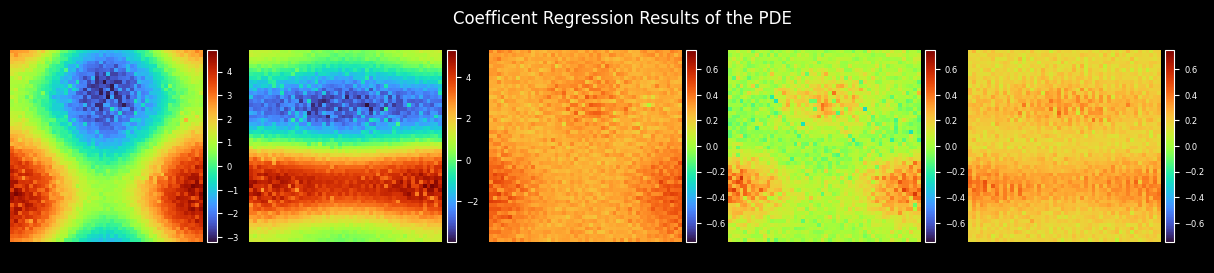

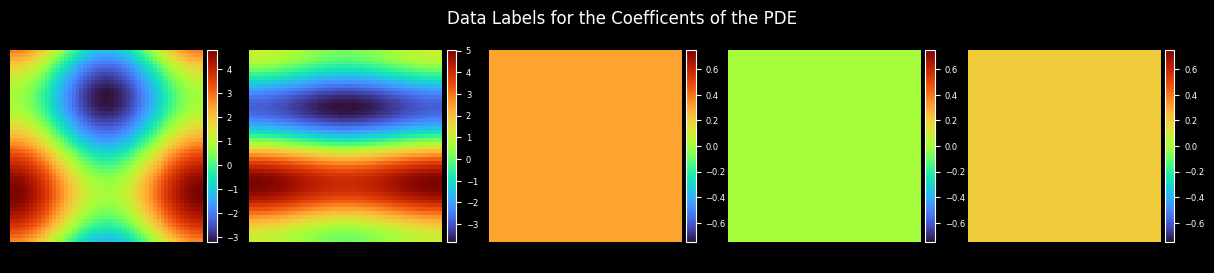

In [10]:
coe_label = get_label_coe(max_order=config["max_order"], resolution=config["mesh_size"])
coes_out_dir = os.path.join(config["figure_out_dir"], "coes")
plot_coe(model.coe, coes_out_dir, prefix="coe_trained", step=step, title="Coefficient Regression Results of the PDE")
plot_coe(coe_label, coes_out_dir, prefix="coe_label", title="Data Labels for the Coefficients of the PDE")

### Plot Test Error

Mindrecorder saved
sample 20, MSE Loss 0.0435892


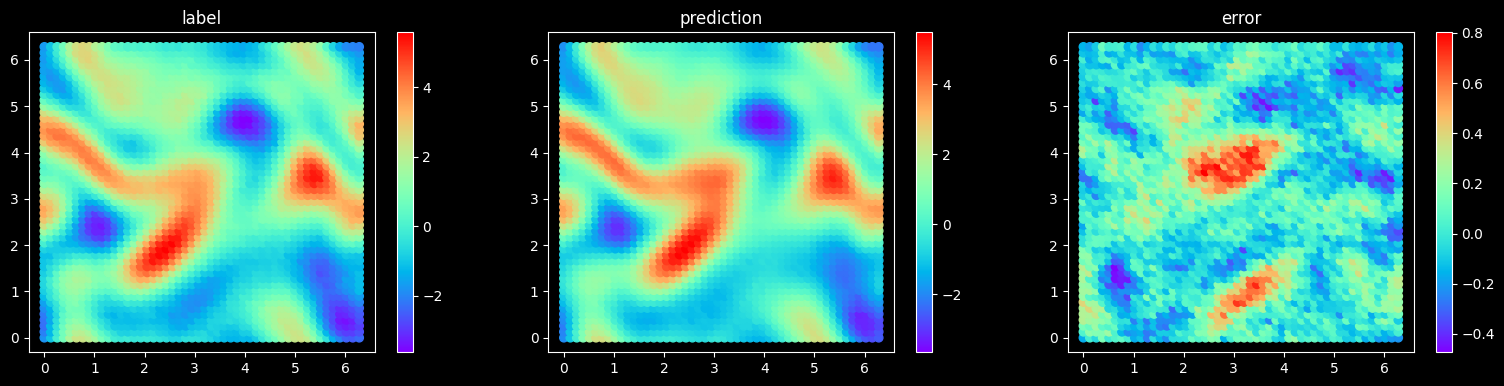

In [11]:
dataset = create_dataset(config, step, "eval.mindrecord", "test", data_size=test_data_size)
test_dataset = dataset.create_test_dataset(step)
iterator_test_dataset = test_dataset.create_dict_iterator()
final_item = [_ for _ in iterator_test_dataset][-1]
plot_test_error(problem, get_loss_metric("mse"), final_item, step, config["mesh_size"], config["figure_out_dir"])

### Plot Extrapolation Error

Mindrecorder saved


step = 1, p25 = 0.06362, p75 = 0.08358
step = 2, p25 = 0.05081, p75 = 0.08540
step = 3, p25 = 0.05956, p75 = 0.10348
step = 4, p25 = 0.06932, p75 = 0.12030
step = 5, p25 = 0.07549, p75 = 0.13022
step = 6, p25 = 0.07960, p75 = 0.13504
step = 7, p25 = 0.08213, p75 = 0.14048
step = 8, p25 = 0.08632, p75 = 0.14928
step = 9, p25 = 0.08938, p75 = 0.15237
step = 10, p25 = 0.09096, p75 = 0.15364
step = 11, p25 = 0.09429, p75 = 0.15343
step = 12, p25 = 0.09653, p75 = 0.15328
step = 13, p25 = 0.10071, p75 = 0.15435
step = 14, p25 = 0.10253, p75 = 0.15285
step = 15, p25 = 0.10426, p75 = 0.15193
step = 16, p25 = 0.11004, p75 = 0.15410
step = 17, p25 = 0.11229, p75 = 0.15308
step = 18, p25 = 0.11408, p75 = 0.15388
step = 19, p25 = 0.11764, p75 = 0.15384
step = 20, p25 = 0.11799, p75 = 0.15672
step = 21, p25 = 0.11842, p75 = 0.15577
step = 22, p25 = 0.12027, p75 = 0.15648
step = 23, p25 = 0.12105, p75 = 0.15853
step = 24, p25 = 0.12166, p75 = 0.16055
step = 25, p25 = 0.12177, p75 = 0.16084
step = 26

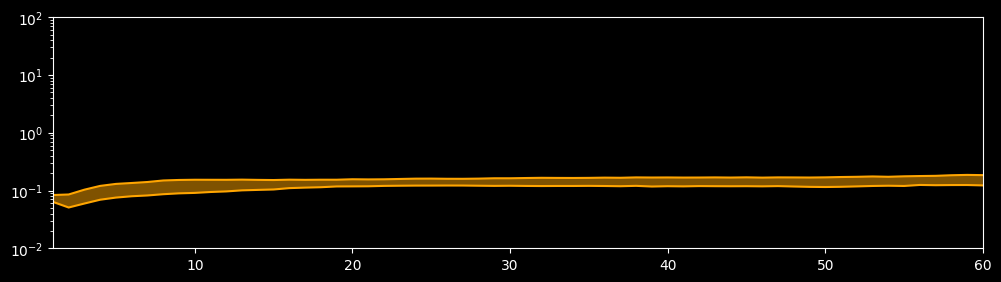

In [12]:
max_step = 60
sample_size = 40

dataset = create_dataset(config, max_step, "extrapolation.mindrecord", "test", data_size=sample_size)
plot_extrapolation_error(config, dataset, max_step=max_step)